### EDA and Feature Selection for Ames IA Housing Data

In [71]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import os
from zipfile import ZipFile

In [32]:
# Unzip Data
files = os.listdir("data/zipfiles")

# Data can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
for file in files:
    if file.endswith(".zip"):
        
        with ZipFile('./data/zipfiles/' + file, 'r') as zipObj:
    
       # Check if it is a shape files
            listOfFileNames = zipObj.namelist()
    
            for fileName in listOfFileNames:
            
                zipObj.extract(fileName, './data')

In [33]:
# Load Training Dataset
train = pd.read_csv("data/train.csv")

# EDA
#### Techniques learned from Dominik Gawlik: https://www.kaggle.com/dgawlik/house-prices-eda

In [34]:
quantitative = [var for var in train.columns if train.dtypes[var] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative  = [var for var in train.columns if train.dtypes[var] == 'object']

### Missing Data

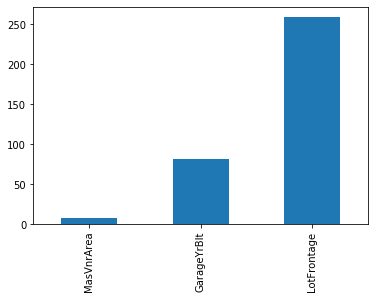

In [35]:
# Visiaulize missing
missing  = train[quantitative].isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar();

In [38]:
# Houses without Garages
train['GarageYrBlt'].fillna(train['YearBuilt'], inplace = True)
# Lot Frontage - missing at random - Replace with 2/3 the Square root of Lot Area
train['LotFrontage'].fillna(2/3 * np.sqrt(train['LotArea']), inplace = True)
#Masonry Veneer Area - missing at random - replace with mean
train['MasVnrArea'].fillna(np.mean(train['MasVnrArea']), inplace = True)

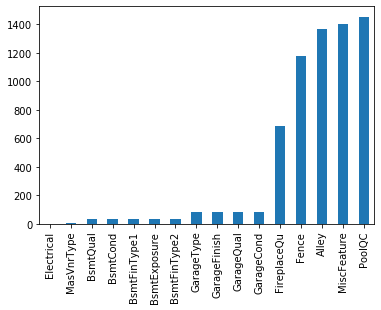

In [39]:
missing  = train[qualitative].isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar();

In [44]:
# Fill Qualitative missings
train.fillna('NONE',inplace = True)

### Check Distributions of variables

In [45]:
# Remove outliers from House size feature based on data documentation
indexNames = train[train['GrLivArea'] > 4000].index
train.drop(indexNames, inplace = True)

indexNames = train[train['SalePrice'] > 500000].index
train.drop(indexNames, inplace = True)

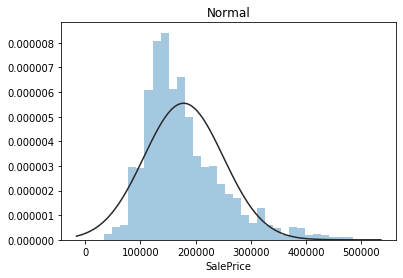

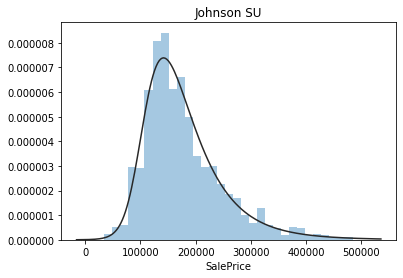

In [47]:
# Check distribution of target variable
y = train['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde = False, fit = st.norm);
plt.figure(2); plt.title('Johnson SU')
sns.distplot(y, kde = False, fit = st.johnsonsu);

In [48]:
# Apply Shapiro-Wilk test for normality of quantitaitve variables, rejecting for p < 0.05
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.05
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


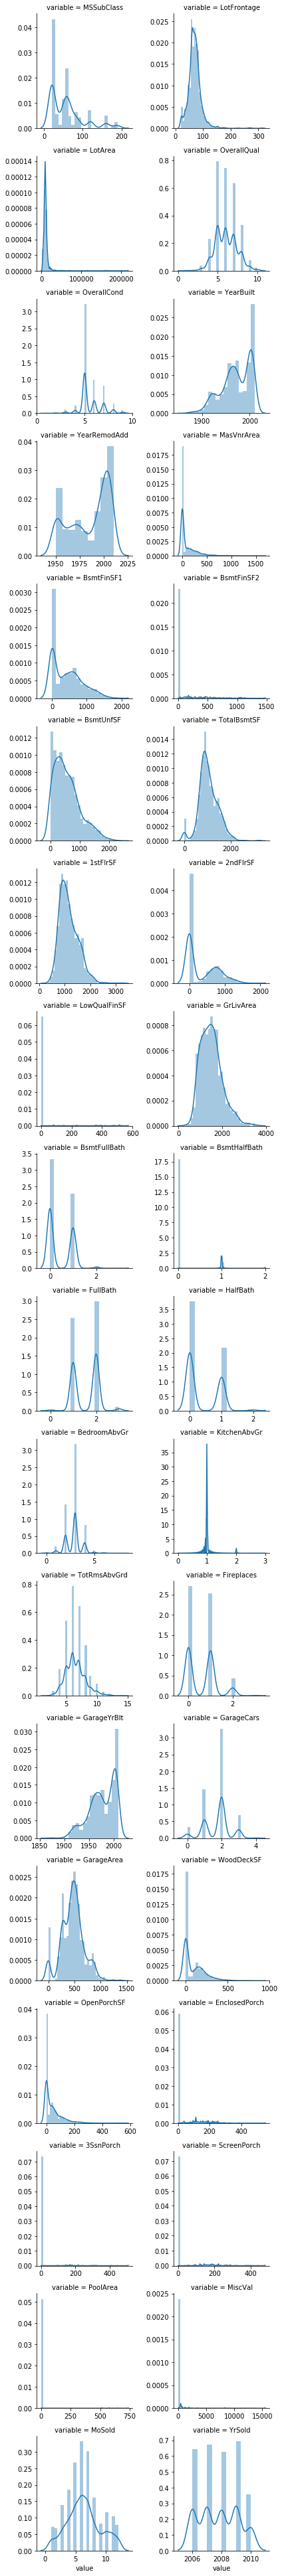

In [49]:
# Check Distribution of quantitative vars

f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")



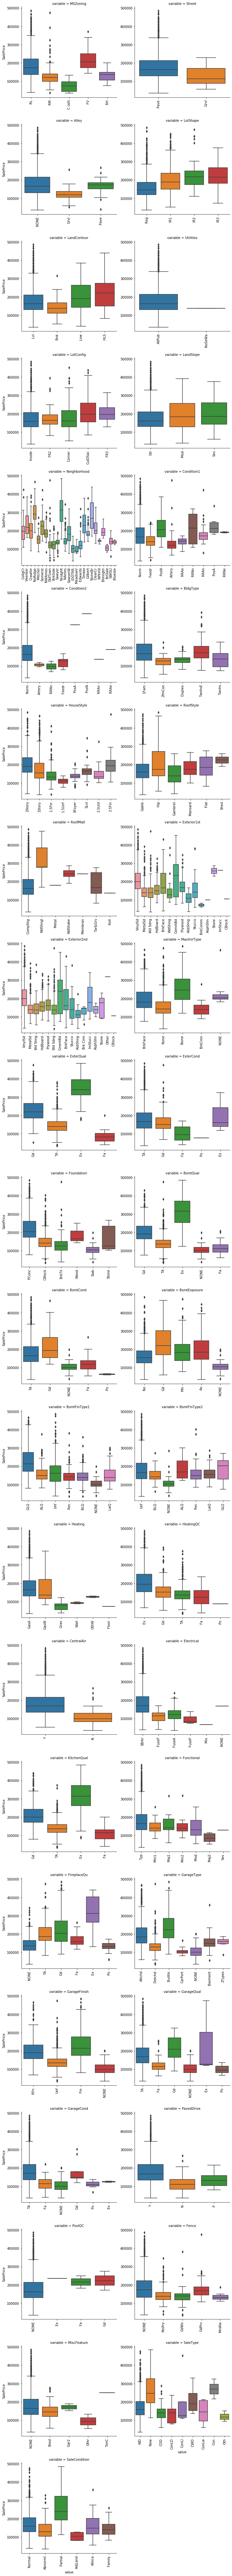

In [52]:
# Check distribution of qualitative
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")



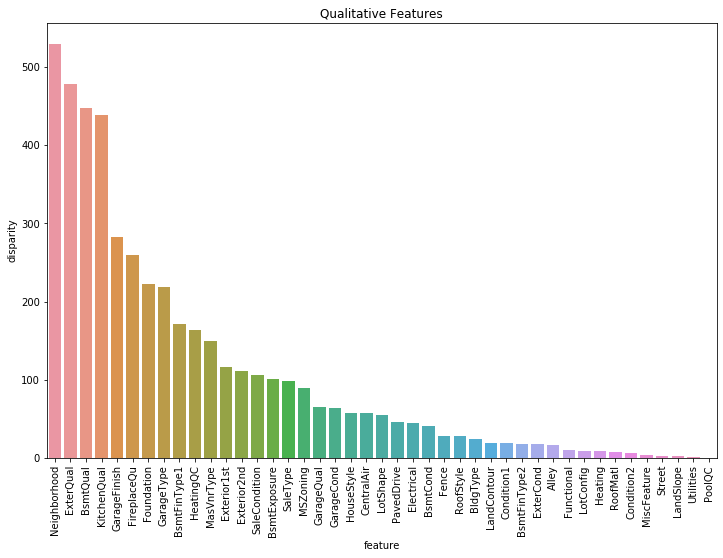

In [81]:
# Perform Anova Test to see relationship of qualitative vars on sale price|

def anova(df):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize = (12,8)); plt.title('Qualitative Features'); 
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)


In [54]:
# Encode Categorical vars to ordinal ranking based on Sales Price mean
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        df.loc[df[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


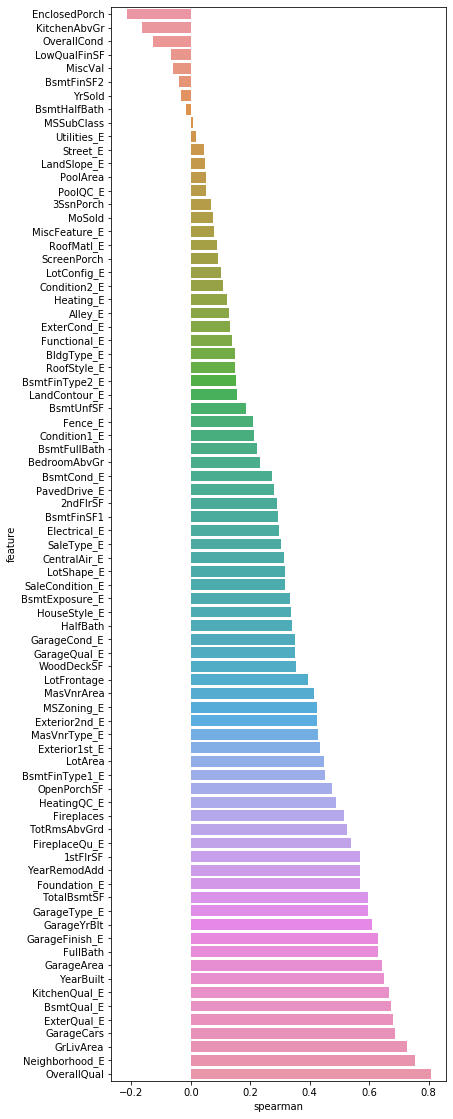

In [55]:
def spearman(df, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [df[f].corr(df['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)


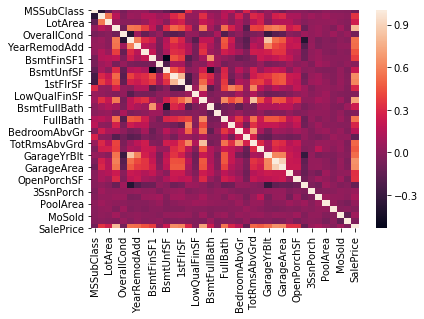

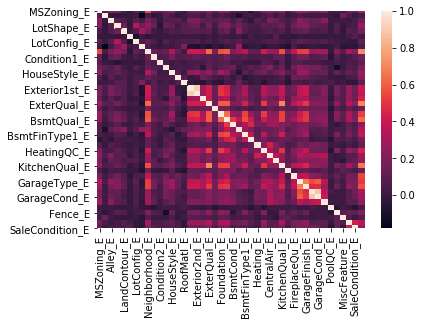

In [56]:
# Correlations


plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)

In [69]:
# Check the strenght of each continuous variable against target variable

cont_attrib_strength = dict()

for cont_attrib in quantitative:
    
    strength_test = LinearRegression()
    
    stength_test.fit(X = train[[cont_attrib]],
                     y = train['SalePrice'])
    cont_attrib_strength.update({cont_attrib: stength_test.score(X = train[[cont_attrib]],
                                                                y = train['SalePrice'])})
    
cont_attrib_strength 

{'MSSubClass': 0.007387169225996915,
 'LotFrontage': 0.11788826937335106,
 'LotArea': 0.06569254674449054,
 'OverallQual': 0.6518962581602294,
 'OverallCond': 0.005222861721543293,
 'YearBuilt': 0.2965899291205618,
 'YearRemodAdd': 0.2833589773743477,
 'MasVnrArea': 0.19784832304724098,
 'BsmtFinSF1': 0.1438617988528671,
 'BsmtFinSF2': 0.00019773438665293686,
 'BsmtUnfSF': 0.050156129382222914,
 'TotalBsmtSF': 0.40351324565090163,
 '1stFlrSF': 0.3791223222189477,
 '2ndFlrSF': 0.08615200479341889,
 'LowQualFinSF': 0.0005738096178196095,
 'GrLivArea': 0.5104800344570468,
 'BsmtFullBath': 0.05662434869960253,
 'BsmtHalfBath': 0.0010938373264799406,
 'FullBath': 0.3074430917596418,
 'HalfBath': 0.08091366403037004,
 'BedroomAbvGr': 0.027745201330654945,
 'KitchenAbvGr': 0.02041579671222493,
 'TotRmsAbvGrd': 0.2651719405911819,
 'Fireplaces': 0.2233984299973173,
 'GarageYrBlt': 0.280346110333649,
 'GarageCars': 0.4290790863898801,
 'GarageArea': 0.4090289449679755,
 'WoodDeckSF': 0.11043838

In [72]:
# Create chi-squared tests to test strength of categorical variables
categ_attrib_strength = dict()
for categ_attrib in qualitative:
    
    
    contingency_table = sm.stats.Table.from_data(train[['SalePrice', categ_attrib]])\
                                .test_ordinal_association()
    categ_attrib_strength.update({categ_attrib : {'zscore' : contingency_table.zscore,
                                                  'pvalue' : contingency_table.pvalue}})
pd.DataFrame.from_dict(data = categ_attrib_strength,
                       orient = 'index').sort_values(by = 'zscore',
                                                     ascending = False)

,zscore,pvalue
Foundation,5.529552,3.210492e-08
RoofMatl,4.877478,1.074510e-06
LandSlope,4.335024,1.457443e-05
HouseStyle,3.749896,1.769081e-04
RoofStyle,3.698956,2.164884e-04
Utilities,3.371463,7.477017e-04
Condition1,2.999026,2.708440e-03
Heating,2.792344,5.232777e-03
Condition2,2.395848,1.658196e-02
BldgType,2.373352,1.762747e-02


In [73]:
# Check strength of encoded categorical variables

cont_attrib_strength = dict()

for cont_attrib in qual_encoded:
    
    strength_test = LinearRegression()
    
    stength_test.fit(X = train[[cont_attrib]],
                     y = train['SalePrice'])
    cont_attrib_strength.update({cont_attrib: stength_test.score(X = train[[cont_attrib]],
                                                                y = train['SalePrice'])})
    
cont_attrib_strength 

{'MSZoning_E': 0.12024595167770757,
 'Street_E': 0.001859411099125463,
 'Alley_E': 0.02133265751438218,
 'LotShape_E': 0.07078226041772129,
 'LandContour_E': 0.027516402278584318,
 'Utilities_E': 0.0002220849543829173,
 'LotConfig_E': 0.013688349518123255,
 'LandSlope_E': 0.002786142614363718,
 'Neighborhood_E': 0.5118913015503643,
 'Condition1_E': 0.02825254233816843,
 'Condition2_E': 0.011254195094394515,
 'BldgType_E': 0.03283824294994442,
 'HouseStyle_E': 0.07791777074478523,
 'RoofStyle_E': 0.04387102424631773,
 'RoofMatl_E': 0.013848724926580847,
 'Exterior1st_E': 0.1660749951149715,
 'Exterior2nd_E': 0.1542316200336853,
 'MasVnrType_E': 0.18515211034519752,
 'ExterQual_E': 0.4799728609848355,
 'ExterCond_E': 0.022879313271114032,
 'Foundation_E': 0.2730630869608017,
 'BsmtQual_E': 0.40078102924232173,
 'BsmtCond_E': 0.057935414380086765,
 'BsmtExposure_E': 0.12672987027589122,
 'BsmtFinType1_E': 0.15415397880253834,
 'BsmtFinType2_E': 0.027922897143159205,
 'Heating_E': 0.016136

In [75]:
# Feature selection

features = ['OverallQual', 'Neighborhood_E', 'GrLivArea', 'GarageCars',
            'ExterQual_E', 'BsmtQual_E', 'KitchenQual_E', 'GarageType_E', 'Foundation_E'
           'YearBuilt', 'GarageArea', 'FullBath', 'GarageFinish_E', 'TotalBsmtSF']


quantitative = ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea', 'FullBath',  'TotalBsmtSF']
qual_encoded       = ['ExterQual_E', 'BsmtQual_E', 'KitchenQual_E',
                      'Neighborhood_E','GarageFinish_E', 'GarageType_E',
                     'Foundation_E']


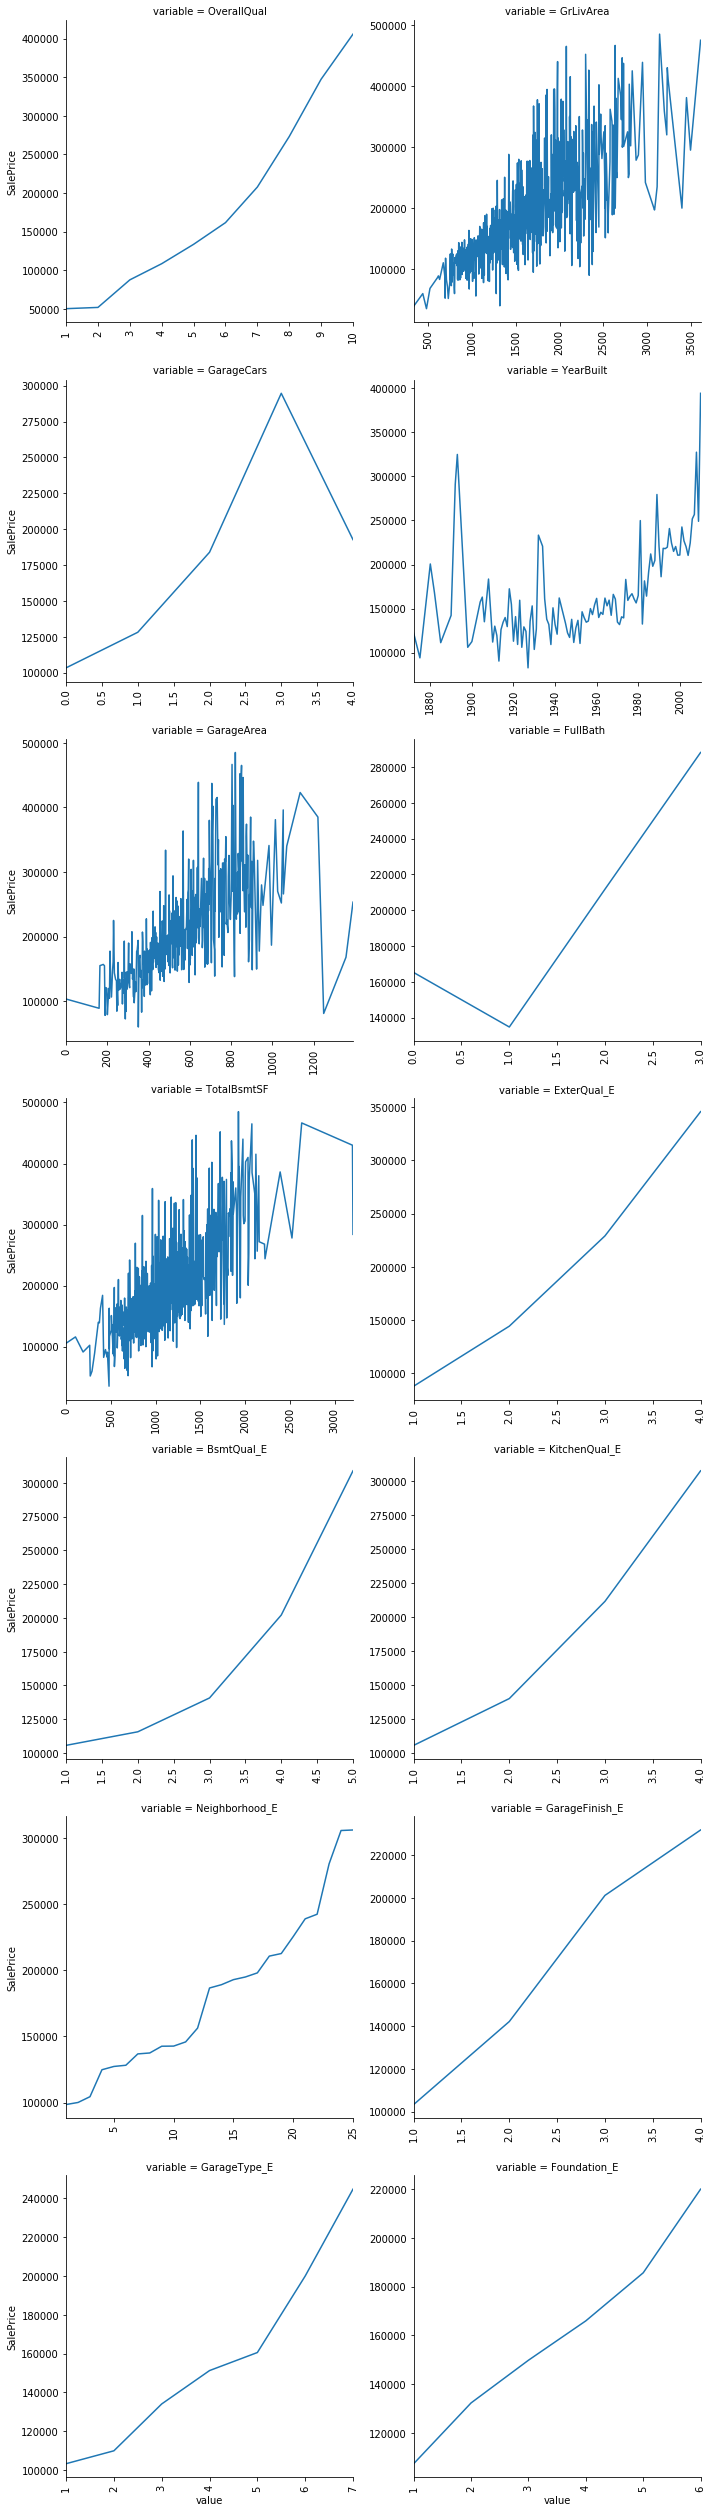

In [76]:
# Check relationship between target and features

def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "SalePrice")




In [77]:
# Transform feature sbased on distributions

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    

log_transform('GrLivArea')
log_transform('GarageArea')
log_transform('TotalBsmtSF')

quadratic('OverallQual')
quadratic('TotalBsmtSF')
quadratic('Neighborhood_E')


qdr = ['OverallQual2',  'TotalBsmtSF2', 'Neighborhood_E2']

features = quantitative + qual_encoded + qdr


In [78]:
# Save feature sdataframe for modeling
train[features].to_csv('data/features.csv', header = True)
train['SalePrice'].to_csv('data/target.csv', header = True)
